## Easy Experiment .ipynb File

# train

## import

In [15]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torch.nn.functional as F

import random

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score

import multiprocessing
import timm

from PIL import Image

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [16]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [17]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## configuration

In [18]:
### cofiguration
seed = 4064
check_point_dir_name = 'I_like_focal'

data_dir = './dataset/train/images/'
train_csv_path = './dataset/train/custom_train.csv'
save_dir = f'./checkpoints/{check_point_dir_name}'

train_b_size = 32
valid_b_size = 128
train_ratio = 0.8
epochs = 25
print_interval = 414
lr = 1e-4
model_name = 'efficientnet_b4'
num_labels = 18
loss_function_name = 'FocalLoss' # ex FocalLoss, CrossEntropyLoss
optimizer_name = 'AdamW'
scheduler_name = 'ReduceLROnPlateau'
comment = 'twice but frozen feature extractor but classifier 2 layer'


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


seed_everything(seed)

In [19]:
train_df = pd.read_csv(train_csv_path)
imgs_path = train_df['path'] 
labels = train_df['class'] # input your label feature
stratify_col = train_df['class']

train_paths, valid_paths, train_labels, valid_labels = train_test_split(imgs_path, labels,
                                                                        train_size=0.7,
                                                                        shuffle=True,
                                                                        random_state=seed,
                                                                        stratify=stratify_col)

In [20]:
os.makedirs(save_dir,exist_ok=True)

In [21]:

dict_args = {
'seed' : seed,
'train_b_size': train_b_size,
'epochs' : epochs,
'lr' : 1e-4,
'model_name' : model_name,
'num_labels' : num_labels,
'train_ratio': train_ratio,
'loss_function_name' : loss_function_name,
'optimizer_name' : optimizer_name,
'scheduler_name' : scheduler_name,
'comment' : comment
}

In [22]:
with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(dict_args, f, ensure_ascii=False, indent=4)

## datasets class

In [23]:
class CustomTrainDataset(Dataset):
    ## input pd.Series
    ## output np.ndarray
    ## change dummy, if label_col is 'gender' or 'mask_state'
    def __init__(self, img_paths : pd.Series, labels : pd.Series, label_col='class', transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        if label_col == 'gender':
            self.labels = pd.get_dummies(labels).to_numpy()
        elif label_col == 'mask_state':
            self.labels = pd.get_dummies(labels).to_numpy()
        else: # age, classes
            self.labels = labels.to_numpy()
        ## if (False), assert occur
        assert self.transforms is not None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

## augmentations

In [24]:
train_transforms = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.GaussianBlur(p=0.2),
        A.GridDistortion(p=0.2),
        A.Rotate(limit = 15, p=0.5),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])
    
valid_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])

In [25]:
# train_transforms = A.Compose([A.Resize(height=224, width=224),
#                               A.HorizontalFlip(p=0.5),
#                               A.RandomBrightnessContrast(p=0.5),
#                               A.GaussianBlur(p=0.5),
#                               A.GridDistortion(p=0.5),
#                               A.Rotate(limit=30, p=0.5),
#                               A.Normalize(mean=(0.56019358,0.52410121,0.501457),
#                               std=(0.23318603,0.24300033,0.24567522)),
#                               ToTensorV2()])

# valid_transforms = A.Compose([A.Resize(height=224, width=224),
#                               A.Normalize(mean=(0.56019358,0.52410121,0.501457),
#                               std=(0.23318603,0.24300033,0.24567522)),
#                               ToTensorV2()])

## make dataset and dataloader

In [26]:
train_dset = CustomTrainDataset(train_paths, train_labels, 'class', train_transforms)
val_dset = CustomTrainDataset(valid_paths, valid_labels, 'class', valid_transforms)

In [27]:
train_loader = DataLoader(
        train_dset,
        batch_size=train_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=False,
    )

val_loader = DataLoader(
        val_dset,
        batch_size=valid_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

## visualization transform

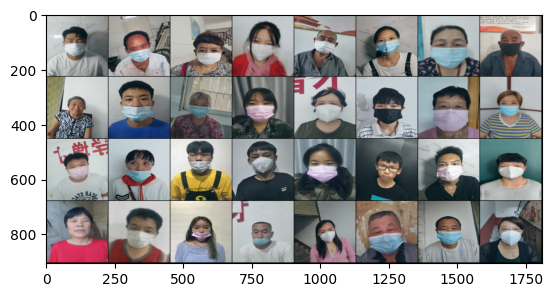

In [28]:
## for check transform
imgs, labels = next(iter(train_loader))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

## Model

In [29]:
os.getcwd()

'/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064'

In [30]:
def freeze_all_params(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False

In [31]:
## Age regression model

reg_model = timm.create_model(model_name='resnet34', pretrained=True, num_classes=1)
reg_model.to(device)
reg_model.load_state_dict(torch.load('./checkpoints/age_regression_resnet/best.pth'))
freeze_all_params(reg_model)

In [32]:
reg_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [33]:
## Mask Gender classification model

classification_model = timm.create_model(model_name=model_name, pretrained=True, num_classes=6)
classification_model.classifier = nn.Linear(1792, 6)
classification_model.to(device)
classification_model.load_state_dict(torch.load('./checkpoints/mask_gender_classification/best.pth'))
# freeze_all_params(classification_model)

<All keys matched successfully>

In [34]:
classification_model

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [35]:
512+1792

2304

In [36]:
(512+1792)/2

1152.0

In [37]:
class TwiceNet(nn.Module):
    def __init__(self, reg_model, cls_model):
        super(TwiceNet, self).__init__()
        self.reg_model = reg_model
        self.cls_model = cls_model
        self.reg_model = self.cut_last_layer(self.reg_model)
        self.cls_model = self.cut_last_layer(self.cls_model)
        self.classifier = nn.Linear(512+1792, 1152)
        self.classifier2 = nn.Linear(1152,18)

    def cut_last_layer(self, model):
        model = torch.nn.Sequential(*(list(model.children())[:-2]))
        return model

    def concat_channel(self, fm1, fm2):
        concated_fm = torch.cat((fm1,fm2), dim=1)
        return concated_fm
    
    def forward(self, x):
        fm1 = self.reg_model(x)
        fm2 = self.cls_model(x)
        concatened_fm = self.concat_channel(fm1, fm2)
        features = F.adaptive_avg_pool2d(concatened_fm, (1,1))
        features = features.squeeze()
        x = self.classifier(features)
        return x

In [38]:
model = TwiceNet(reg_model, classification_model).to(device)
dummy = torch.Tensor(2,3,224,224).to(device)
model(dummy)

tensor([[ 0.8635,  0.8350,  0.3266,  ...,  0.4867,  0.1223, -0.3551],
        [ 0.9992,  0.9463,  0.4737,  ...,  0.4189,  0.1784, -0.1117]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [39]:
!nvidia-smi

Fri Oct 28 16:30:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   35C    P0    36W / 250W |   1783MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loss function

In [40]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [41]:
if loss_function_name == 'CrossEntropyLoss':
    criterion = nn.CrossEntropyLoss()
elif loss_function_name == 'FocalLoss':
    criterion = FocalLoss()
else:
    raise ValueError(f'not implement Loss function : {loss_function_name}')

## Optimizer

In [42]:
# if you param freeze, not update during training
optimizer = None
if optimizer_name == 'AdamW':
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr) 
else:
    raise ValueError(f'not implement Optimizer : {optimizer_name}')

## Scheduler  

In [43]:
scheduler = None

if scheduler_name == 'ReduceLROnPlateau':
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=1e-5) ## 정리

assert scheduler != None , 'sheduler is None'

## Train

In [44]:

best_val_acc = 0
best_val_f1 = 0
best_val_loss = np.Inf

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    iter_preds = []
    iter_labels = []

    for idx, train_batch in enumerate(train_loader):
        b_imgs, b_labels = train_batch # batch imgs and batch labels
        b_imgs = b_imgs.to(device)
        b_labels = b_labels.to(device)

        b_logits = model(b_imgs)
        b_loss = criterion(b_logits, b_labels)
        b_preds = torch.argmax(b_logits, dim=-1)

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        epoch_loss += b_loss.item()
        epoch_preds += b_preds.detach().cpu().numpy().tolist()
        epoch_labels += b_labels.detach().cpu().numpy().tolist()

        # print interval batch
        if(idx+1) % print_interval == 0:
            current_loss = epoch_loss / (idx+1) # /batch
            correct_list = [i==j for i,j in zip(epoch_preds, epoch_labels)]
            current_acc = sum(correct_list) / len(correct_list)
            print(
                    f"Epoch[{epoch+1}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                    f"training loss {current_loss:2.4f} || training accuracy {current_acc:4.2%} || lr {lr}"
                )

    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()

        val_loss = []
        val_acc = []

        val_preds = [] # every data's preds
        val_labels = [] # every data's label

        for idx, val_batch in enumerate(val_loader):
            imgs, labels = val_batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            # print('labels shape:', labels.size())

            logits = model(imgs)
            b_loss = criterion(logits, labels).item()
            
            preds = torch.argmax(logits, dim=-1)
            # print('preds shape:', preds.size())

            correct_num = (labels == preds).sum().item()

            val_loss.append(b_loss)
            val_acc.append(correct_num)

            val_preds += preds.detach().cpu().numpy().tolist()
            val_labels += labels.detach().cpu().numpy().tolist()

        epoch_val_loss =  np.sum(val_loss)/len(val_loader)
        epoch_val_acc = np.sum(val_acc)/len(val_dset)
        epoch_val_f1 = f1_score(val_labels, val_preds, average='macro')
        
        best_val_loss = min(best_val_loss, epoch_val_loss)

        if epoch_val_f1 > best_val_f1:
                print(f"New best model for val f1 : {epoch_val_f1:2.4f}! saving the best model..")
                best_val_f1 = epoch_val_f1
                torch.save(model.state_dict(), f"{save_dir}/best.pth")
        if epoch_val_acc > best_val_acc:
                best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), f'{save_dir}/last.pth')
        print(
                f"[Val] f1 : {epoch_val_f1:2.4f}, loss: {epoch_val_loss:2.4f}, acc: {epoch_val_acc:4.2%} || "
                f"best f1 : {best_val_f1:2.4f}, best loss: {best_val_loss:2.4f}, best acc: {best_val_acc:4.2%}"
            )
        scheduler.step(epoch_val_loss)
        print()


Epoch[1/25](414/414) || training loss 0.5032 || training accuracy 84.32% || lr 0.0001
Calculating validation results...
New best model for val f1 : 0.7919! saving the best model..
[Val] f1 : 0.7919, loss: 0.0541, acc: 92.50% || best f1 : 0.7919, best loss: 0.0541, best acc: 92.50%

Epoch[2/25](414/414) || training loss 0.0516 || training accuracy 93.93% || lr 0.0001
Calculating validation results...
New best model for val f1 : 0.8369! saving the best model..
[Val] f1 : 0.8369, loss: 0.0361, acc: 94.44% || best f1 : 0.8369, best loss: 0.0361, best acc: 94.44%

Epoch[3/25](414/414) || training loss 0.0308 || training accuracy 96.44% || lr 0.0001
Calculating validation results...
New best model for val f1 : 0.9031! saving the best model..
[Val] f1 : 0.9031, loss: 0.0223, acc: 96.68% || best f1 : 0.9031, best loss: 0.0223, best acc: 96.68%

Epoch[4/25](414/414) || training loss 0.0171 || training accuracy 98.17% || lr 0.0001
Calculating validation results...
New best model for val f1 : 0.9

```
1028_2327
age model freeze
제출 f1 : 0.7061
[Val] f1 : 0.9714, loss: 0.0459, acc: 98.36% || best f1 : 0.9732, best loss: 0.0409, best acc: 98.47%

```

```
1029_0049
non-freeze
제출 f1 : 0.6432
[Val] f1 : 0.9905, loss: 0.0151, acc: 98.87% || best f1 : 0.9905, best loss: 0.0151, best acc: 98.91%
```

```
1029_0124
mask,gender model freeze + 2 layer classifier
제출 f1 : 	0.6194
[Val] f1 : 0.9889, loss: 0.0241, acc: 98.75% || best f1 : 0.9889, best loss: 0.0241, best acc: 98.75%


```

```
age model freeze + focal
[Val] f1 : 0.9743, loss: 0.0087, acc: 98.59% || best f1 : 0.9752, best loss: 0.0082, best acc: 98.62%

```

# inference

## inference config

In [55]:
model_name = 'twice'
check_point_dir_name = 'I_like_focal'
save_file_path = f'./checkpoints/{check_point_dir_name}/best.pth'
test_dir = './dataset/eval/images/'
test_csv_path = './dataset/eval/info.csv'

test_b_size = 256
num_labels = 18
sumbission_csv_name = 'result'

## checkpoint model load

In [46]:
save_file_path

'./checkpoints/I_like_focal/best.pth'

In [47]:
model.to(device)
model.load_state_dict(torch.load(save_file_path))

<All keys matched successfully>

## test dataset

In [48]:
model

TwiceNet(
  (reg_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [49]:
class CustomTestDataset(Dataset):
    def __init__(self, img_paths:list, transforms=None):
        self.img_paths = img_paths
        self.transforms = transforms
        assert self.transforms is not None, 'you must use transforms in Testset'

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        img = np.array(img)
        img = self.transforms(image=img)["image"]
        return img

    def __len__(self):
        return len(self.img_paths)

In [50]:
test_transforms = A.Compose([
                            A.Resize(224, 224),
                            A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
                            ToTensorV2()
                            ])

In [51]:
info = pd.read_csv(test_csv_path)
test_imgs_path = [os.path.join(test_dir, img_id) for img_id in info.ImageID]

In [52]:
test_dset = CustomTestDataset(test_imgs_path, test_transforms)

In [53]:
test_loader = DataLoader(
        test_dset,
        batch_size=test_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

## inference run

In [54]:
test_preds = []
with torch.no_grad():
        for idx, images in enumerate(test_loader):
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            test_preds.extend(pred.cpu().numpy().tolist())

info['ans'] = test_preds
save_path = os.path.join(save_dir, f'{sumbission_csv_name}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")
print()

Inference Done! Inference result saved at ./checkpoints/I_like_focal/result.csv

